In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import models
from torchvision import transforms as T
import torch.nn.functional as F

In [4]:
# Load pre-trained VGG19
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False) # Freeze all weights

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
# Normalized using mean and std of ImageNet
# Available in Pytorch documentation -- https://pytorch.org/vision/stable/models.html
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [8]:
def transformation(img):
  tasks = T.Compose([
                     T.Resize(256),
                     T.ToTensor(),
                     T.Normalize(mean=mean, std=std)
  ])

  img = tasks(img)
  img = img.unsqueeze(0) # Add batch dimension
  return img

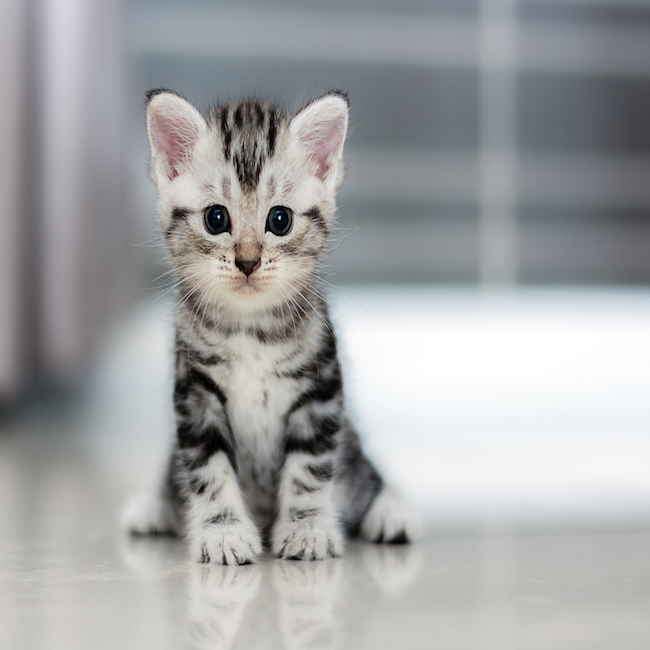

In [9]:
content_img = Image.open("cat.jpg").convert('RGB')
content_img

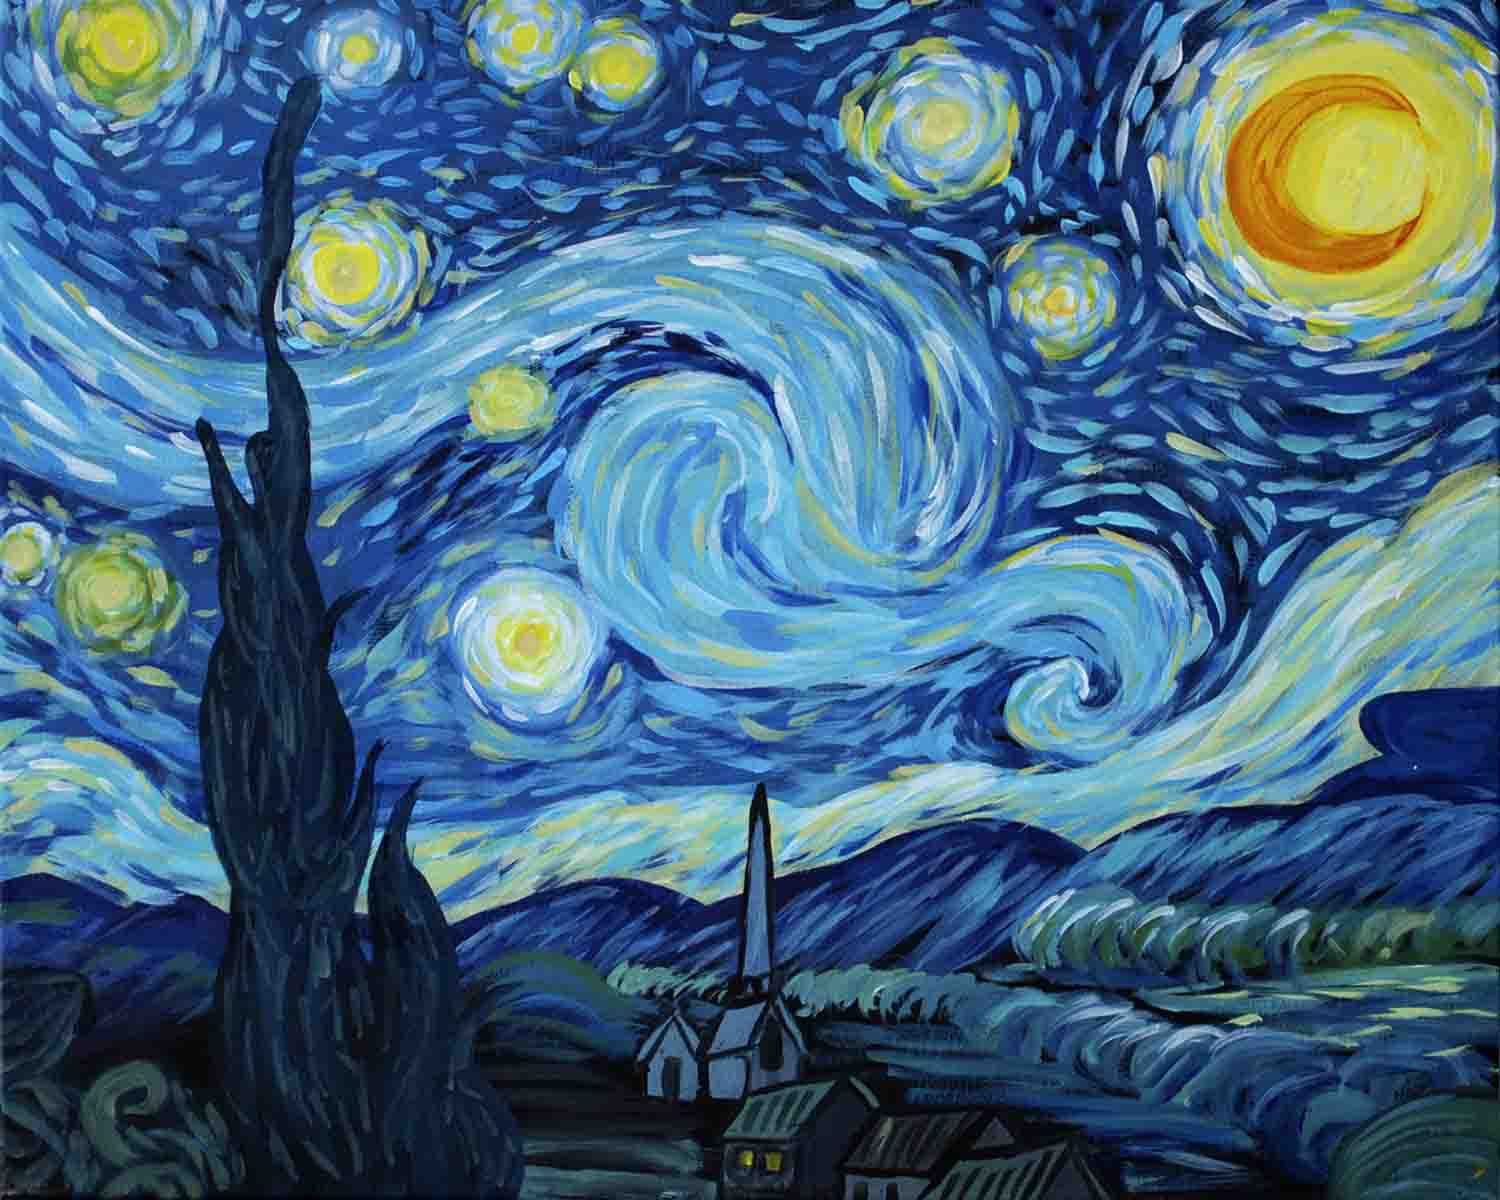

In [10]:
style_img = Image.open("starry_night.jpg").convert("RGB")
style_img

In [11]:
content_img.size, style_img.size

((650, 650), (1500, 1200))

In [12]:
content_img = transformation(content_img).to(device)
style_img = transformation(style_img).to(device)

In [13]:
content_img.shape, style_img.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 320]))

In [16]:
def tensor_to_image(tensor):

  image = tensor.clone().detach()
  image = image.cpu().numpy().squeeze() # Remove batch dimension

  image = image.transpose(1, 2, 0) # (c, h, w) -> (h, w, c)
  image *= np.array(std) + np.array(mean)
  image = image.clip(0, 1)

  return image

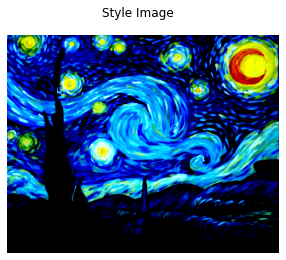

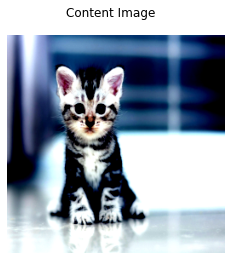

In [18]:
img = tensor_to_image(style_img)
fig = plt.figure()
fig.suptitle('Style Image')
plt.imshow(img)
plt.axis('off');

img = tensor_to_image(content_img)
fig = plt.figure()
fig.suptitle('Content Image')
plt.imshow(img)
plt.axis('off');

In [19]:
# Specifying Layers of Interest to get Content and Style Information
LAYERS_OF_INTEREST = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
}
# Earlier layers contain details
# Higher layers have more complex and abstracted information

In [22]:
def apply_model_and_extract_features(image, model):

  x = image
  features = {}

  for name, layer in model._modules.items():
    x= layer(x)

    if name in LAYERS_OF_INTEREST:
      features[LAYERS_OF_INTEREST[name]] = x
  
  return features

In [23]:
content_img_features = apply_model_and_extract_features(content_img, vgg)
style_img_features = apply_model_and_extract_features(style_img, vgg)

In [24]:
for layer in content_img_features:
  print(f'{layer}: {content_img_features[layer].shape}')

conv1_1: torch.Size([1, 64, 256, 256])
conv2_1: torch.Size([1, 128, 128, 128])
conv3_1: torch.Size([1, 256, 64, 64])
conv4_1: torch.Size([1, 512, 32, 32])
conv4_2: torch.Size([1, 512, 32, 32])
conv5_1: torch.Size([1, 512, 16, 16])


In [25]:
for layer in style_img_features:
  print(f'{layer}: {style_img_features[layer].shape}')

conv1_1: torch.Size([1, 64, 256, 320])
conv2_1: torch.Size([1, 128, 128, 160])
conv3_1: torch.Size([1, 256, 64, 80])
conv4_1: torch.Size([1, 512, 32, 40])
conv4_2: torch.Size([1, 512, 32, 40])
conv5_1: torch.Size([1, 512, 16, 20])


In [26]:
def calculate_gram_matrix(tensor):
  """
  Gram Matrix preserves style information by flattening feature maps and calculating its dot product with itself. This is used for calculating style loss.
  """
  _, channels, height, width = tensor.size()
  tensor = tensor.view(channels, height * width) # (c, h, w) -> (c, h * w) Flattening feature map
  gram_matrix = torch.mm(tensor, tensor.t()) # Dot product of flattened feature map with its transpose
  gram_matrix = gram_matrix.div(channels * height * width) # Normalize so that large feature maps do not disproportionately affect the result
  
  return gram_matrix

In [27]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}
style_features_gram_matrix

{'conv1_1': tensor([[1.2129e-03, 1.0880e-03, 8.0375e-05,  ..., 3.0239e-03, 4.5621e-04,
          1.5102e-03],
         [1.0880e-03, 1.5716e-02, 6.8127e-05,  ..., 1.5031e-02, 2.6219e-03,
          6.0778e-03],
         [8.0375e-05, 6.8127e-05, 1.2540e-04,  ..., 4.1115e-06, 6.5670e-05,
          1.6760e-04],
         ...,
         [3.0239e-03, 1.5031e-02, 4.1115e-06,  ..., 6.2786e-02, 9.8608e-03,
          1.3948e-02],
         [4.5621e-04, 2.6219e-03, 6.5670e-05,  ..., 9.8608e-03, 4.0372e-03,
          2.2530e-03],
         [1.5102e-03, 6.0778e-03, 1.6760e-04,  ..., 1.3948e-02, 2.2530e-03,
          1.1564e-02]], device='cuda:0'),
 'conv2_1': tensor([[0.0324, 0.0070, 0.0156,  ..., 0.0287, 0.0033, 0.0075],
         [0.0070, 0.0402, 0.0095,  ..., 0.0496, 0.0092, 0.0092],
         [0.0156, 0.0095, 0.0290,  ..., 0.0305, 0.0023, 0.0053],
         ...,
         [0.0287, 0.0496, 0.0305,  ..., 0.2002, 0.0207, 0.0261],
         [0.0033, 0.0092, 0.0023,  ..., 0.0207, 0.0231, 0.0102],
         [0.

In [29]:
weights = dict(conv1_1=1.0, conv2_1=0.75, conv3_1=0.35,
               conv4_1=0.25, conv5_1=0.15)
weights

{'conv1_1': 1.0,
 'conv2_1': 0.75,
 'conv3_1': 0.35,
 'conv4_1': 0.25,
 'conv5_1': 0.15}

In [33]:
target = content_img.clone().requires_grad_(True).to(device) # Target image weights are trained to minimize content and style loss
optimizer = optim.Adam([target], lr=0.003)

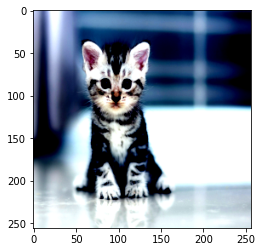

In [34]:
plt.imshow(tensor_to_image(target)) # Same as content image before training

In [35]:
for i in range(1, 2001):

  target_features = apply_model_and_extract_features(target, vgg)

  content_loss = F.mse_loss(target_features['conv4_2'], content_img_features['conv4_2']) # calculate content loss

  # calculate style loss
  style_loss = 0

  for layer in weights:

    target_feature = target_features[layer]

    target_gram_matrix = calculate_gram_matrix(target_feature)
    style_gram_matrix = style_features_gram_matrix[layer]

    layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
    layer_loss *= weights[layer]

    _, channels, height, width = target_feature.shape

    style_loss += layer_loss

  total_loss = 1000000 * style_loss + content_loss # Style loss is scaled to be in the same range as Content loss

  if i % 50 == 0:
    print(f'Epoch: {i}, Style Loss: {style_loss:.4f}, Content Loss: {content_loss:.4f}')
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

Epoch: 50, Style Loss: 0.0001, Content Loss: 5.3187
Epoch: 100, Style Loss: 0.0000, Content Loss: 5.5996
Epoch: 150, Style Loss: 0.0000, Content Loss: 5.3962
Epoch: 200, Style Loss: 0.0000, Content Loss: 5.2173
Epoch: 250, Style Loss: 0.0000, Content Loss: 5.0647
Epoch: 300, Style Loss: 0.0000, Content Loss: 4.9437
Epoch: 350, Style Loss: 0.0000, Content Loss: 4.8296
Epoch: 400, Style Loss: 0.0000, Content Loss: 4.7287
Epoch: 450, Style Loss: 0.0000, Content Loss: 4.6477
Epoch: 500, Style Loss: 0.0000, Content Loss: 4.5702
Epoch: 550, Style Loss: 0.0000, Content Loss: 4.4951
Epoch: 600, Style Loss: 0.0000, Content Loss: 4.4290
Epoch: 650, Style Loss: 0.0000, Content Loss: 4.3661
Epoch: 700, Style Loss: 0.0000, Content Loss: 4.3058
Epoch: 750, Style Loss: 0.0000, Content Loss: 4.2514
Epoch: 800, Style Loss: 0.0000, Content Loss: 4.2016
Epoch: 850, Style Loss: 0.0000, Content Loss: 4.1564
Epoch: 900, Style Loss: 0.0000, Content Loss: 4.1114
Epoch: 950, Style Loss: 0.0000, Content Loss: 4

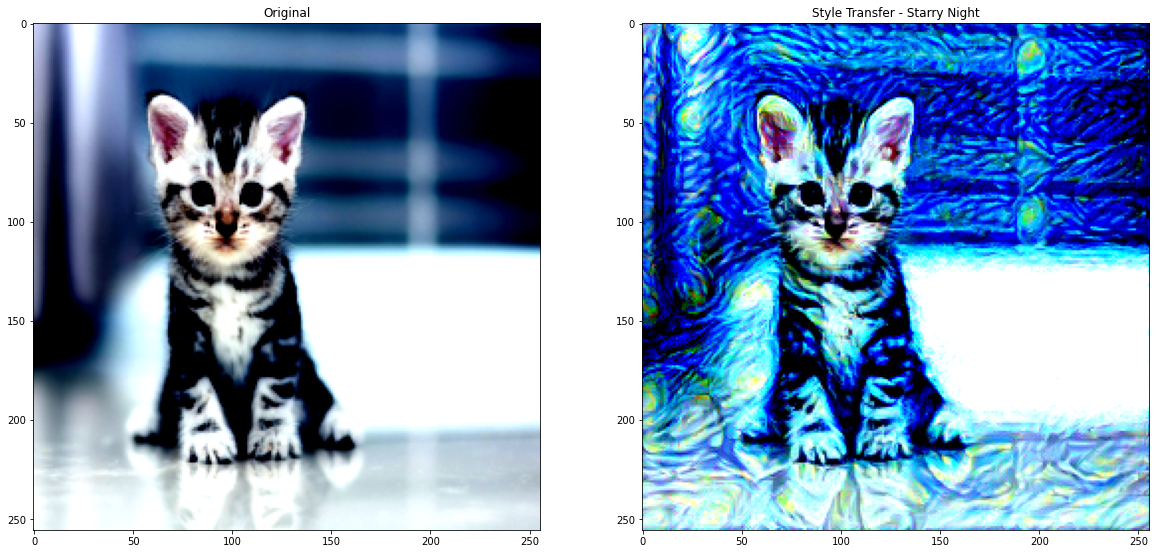

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))
ax1.set_title('Original')
ax2.set_title('Style Transfer - Starry Night');

In [41]:
# Transfer using AlexNet
alexnet = models.alexnet(pretrained=True).features

for param in alexnet.parameters():
  param.requires_grad_(False)

alexnet.to(device)

LAYERS_OF_INTEREST = {
    '0': 'conv1_1',
    '3': 'conv2_1',
    '6': 'conv3_1',
    '8': 'conv3_2',
    '10': 'conv3_3'
}

content_img_features = apply_model_and_extract_features(content_img, alexnet)
style_img_features = apply_model_and_extract_features(style_img, alexnet)

style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.25}

target = content_img.clone().requires_grad_(True).to(device) 
optimizer = optim.RMSprop([target], lr=0.003)


for i in range(1, 2001):

  target_features = apply_model_and_extract_features(target, alexnet)

  content_loss = F.mse_loss(target_features['conv3_1'], content_img_features['conv3_1']) # calculate content loss

  # calculate style loss
  style_loss = 0

  for layer in weights:

    target_feature = target_features[layer]

    target_gram_matrix = calculate_gram_matrix(target_feature)
    style_gram_matrix = style_features_gram_matrix[layer]

    layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
    layer_loss *= weights[layer]

    _, channels, height, width = target_feature.shape

    style_loss += layer_loss

  total_loss = 10000000 * style_loss + content_loss # Style loss is scaled to be in the same range as Content loss

  if i % 50 == 0:
    print(f'Epoch: {i}, Style Loss: {style_loss:.4f}, Content Loss: {content_loss:.4f}')
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

Epoch: 50, Style Loss: 0.0001, Content Loss: 3.5212
Epoch: 100, Style Loss: 0.0000, Content Loss: 3.9930
Epoch: 150, Style Loss: 0.0000, Content Loss: 4.2023
Epoch: 200, Style Loss: 0.0000, Content Loss: 4.3543
Epoch: 250, Style Loss: 0.0000, Content Loss: 4.4713
Epoch: 300, Style Loss: 0.0000, Content Loss: 4.5590
Epoch: 350, Style Loss: 0.0000, Content Loss: 4.6168
Epoch: 400, Style Loss: 0.0000, Content Loss: 4.6574
Epoch: 450, Style Loss: 0.0000, Content Loss: 4.6850
Epoch: 500, Style Loss: 0.0000, Content Loss: 4.7183
Epoch: 550, Style Loss: 0.0000, Content Loss: 4.7529
Epoch: 600, Style Loss: 0.0000, Content Loss: 4.7818
Epoch: 650, Style Loss: 0.0000, Content Loss: 4.8035
Epoch: 700, Style Loss: 0.0000, Content Loss: 4.8104
Epoch: 750, Style Loss: 0.0000, Content Loss: 4.8298
Epoch: 800, Style Loss: 0.0000, Content Loss: 4.8332
Epoch: 850, Style Loss: 0.0000, Content Loss: 4.8458
Epoch: 900, Style Loss: 0.0000, Content Loss: 4.8357
Epoch: 950, Style Loss: 0.0000, Content Loss: 4

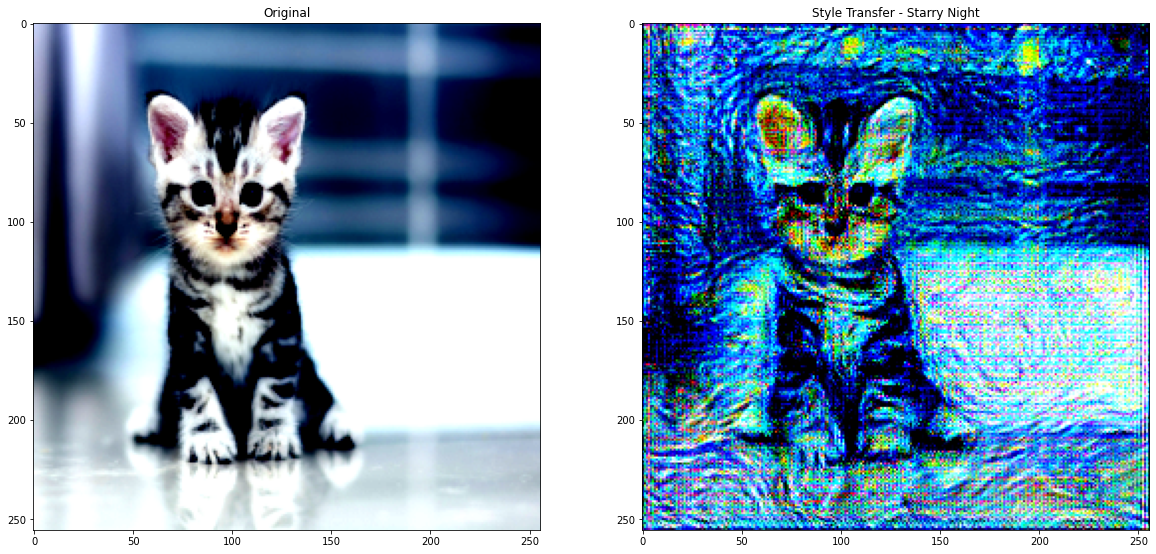

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))
ax1.set_title('Original')
ax2.set_title('Style Transfer - Starry Night');